### Introduzione

Questo notebook ha l'obiettivo di fornire una panoramica visiva dell'algoritmo di discesa del gradiente, uno dei principali algoritmi di ottimizzazione utilizzati nell'apprendimento automatico per minimizzare la funzione di errore.

Per fare ciò, utilizzeremo la funzione di errore MSE:

$MSE = \frac{1}{N} \sum_{i=1}^{N}( (Y_i - \hat{Y_i})^2 )$

Inizieremo creando una distribuzione lineare con del rumore, al fine di mantenere i dati "realistici". Successivamente, utilizzeremo l'algoritmo di discesa del gradiente per ottimizzare i parametri di una semplice regressione lineare fatta manualmente, senza l'utilizzo di librerie di Machine Learning. 

In particolare, ci concentreremo sull'ottimizzazione del parametro __m__ _(il coefficiente angolare)_ della retta di regressione e terremo fisso al _termine noto_ il parametro __c__ _(distanza dall'origine)_, in modo da focalizzare il lavoro di ottimizzazione su un solo parametro e lavorare in uno spazio $R^2$.

In questo modo, potremo analizzare l'andamento dell'errore sulla funzione di costo $L(m, \overline{c})$ e visualizzare come il valore del parametro __m__ si muove verso il minimo della funzione di errore in ogni epoca. Inoltre, attraverso la visualizzazione dell'andamento della funzione di costo al variare del parametro m, potremo avere una panoramica visiva dell'andamento del parametro in casi particolari, come l'esplosione o la scomparsa del gradiente.


Siamo pronti per iniziare!

Facciamo l'import delle varie librerie che andremo ad utilizzare

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from PIL import Image
from IPython.core.display import HTML

### Inizializzazione del Dataset

Iniziamo generando una distribuzione lineare con coefficiente angolare (slope) e una distanza dall'origine (intercept) creati randomicamente.

Per dare senso ai dati rendendoli 'realistici' aggiungiamo all'equazione della distribuzione lineare un _rumore_ creato attraverso una distribuzione normale data da _np.random.normal()_

__noise_factor__ controlla il rumore della distribuzione e verrà utilizzato come parametro di deviazione standard della distribuzione di rumore. Maggiore sarà il valore, maggiore sarà il la distanza dalla distribuzione normale dei punti di rumore

Infine plottiamo il dataset ottenuto e scriviamo i valori "reali" del coefficiente angolare (slope) e della distanza dall'origine (intercept), che saranno poi i parametri __m__ e __c__ da identificare nella nostra regressione lineare

> real_slope (m): 9.540138588033479 
> real_intercept (c): 11.68243651564374


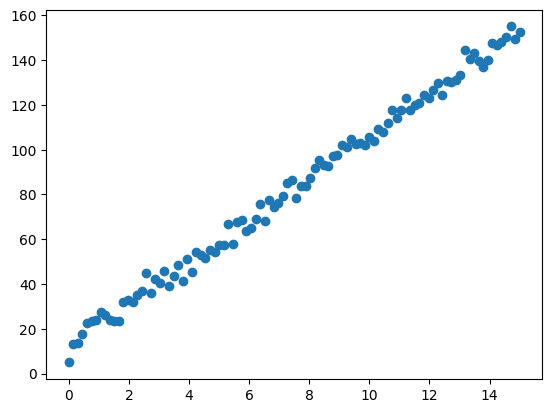

In [2]:
num_points = 100
from_x = 0
to_x = 15

# Parametro per controllare il rumore della distribuzione
noise_factor = 3

#slope = random.uniform(0, 10)
#intercept = random.uniform(0, 10)

slope = 9.540138588033479
intercept = 11.68243651564374


X = np.linspace(from_x, to_x, num_points)
Y = slope*X + intercept + np.random.normal(from_x, noise_factor, num_points)

print ("> real_slope (m): {} \n> real_intercept (c): {}". format(slope, intercept))

# Plot the data
plt.scatter(X, Y)
plt.show()

### Inizializzazione dei parametri (m e c) e definizione degli iperparametri (lr e epochs)


##### PARAMETRO M

Andiamo a settare randomicamente il paremtro __m__ in modo tale che successivamente utilizzeremo la tecnica della discesa del gradiente per ottimizzare questo valore. Volendo possiamo settarlo anche a __zero__ come valore di partenza, ma settarlo ad un valore randomico aiuta poi successivamente ad apprezzare meglio il diverso comportamento del gradient descent in funzione del valore iniziale di __m__


##### PARAMETRO C

Per semplicità, il parametro __c__ lo fissiamo direttaemente noi al valore _noto_ reale, perché in questo contesto vogliamo tenere il lavoro singolarmente sul parametro __m__, in modo da lavorare in $R^2$ quando successivamente analizzeremo l'andamento dell'errore su $L(m, \overline{c})$

##### IPERPARAMETRI

Gli iperparametri __lr__ _(Learning Rate)_ e __epochs__ _(numero di epoche)_ possono essere modificati per testare le conseguenze di queste modifiche sul comportamento del modello

In [3]:
#-------------------
# Parametri
#-------------------

# inizializziamo m a zero
m = 0


# fissiamo c al paramentro reale per concentrarci
# solamente sull'andamento del parametro m
c = intercept

#-------------------
# Iper parametri
#-------------------

# learning Rate
lr = 0.001 

# Numero di epoche
epochs = 100 

Definizione della funzione di errore e delle relative derivate

Definiamo la funzione di funzione di errore e le relative derivate rispetto a m e rispetto a c

In questo contesto utilizziamo la MSE.

$MSE = \frac{1}{N} \sum_{i=1}^{N}( (Y_i - \hat{Y_i})^2 )$

Nel contesto di questo notebook, la derivata rispetto a c non verrà mai utilizzata, poiché come spiegato sopra, il parametro c è già definito sul termine noto e resterà costante per tutto il tempo (quindi non verrà ottimizzata dal gradient descent). Per completezza però, definiamo comunque la derivata della funzione di errore rispetto a c

__Derivata rispetto a m__

$\frac{\partial \mathrm{MSE}}{\partial m} = - \frac{2}{N} \sum_{i=1}^{N}( X_i(Y_i - \hat{Y_i})^2 ) $

__Derivata rispetto a c__

$\frac{\partial \mathrm{MSE}}{\partial c} = - \frac{2}{N} \sum_{i=1}^{N}( (Y_i - \hat{Y_i})^2 ) $

In [4]:
# Definizione della funzione di errore. In questo contesto utilizziamo la MSE
def f_error(n, m, c, X, Y):
    return (1/n) * np.sum( (Y - m*X - c)**2 )


def get_m_derivative(n, X, Y, Y_pred):
    return (-2 / n) * sum(X * (Y - Y_pred)) 

def get_c_derivative(n, Y, Y_pred):
    return (-2 / n) * sum(Y - Y_pred)

### Algoritmo di discesa del gradiente e aggiornaemnto parametri

Andiamo ad effettuare l'algoritmo di discesa del gradiente per il numero di epoche stabilito nella definizione degli iperparametri _(nota che per semplicità in questo esempio non c'è early stopping)_

Ad ogni epoca:

- calcoliamo il valore della predizione sulla base del valore corrente dei parametri __m__ e __c__
- utilizzamo la predizione creata per calcolare le derivate della funzione di errore
- aggiorniamo i parametei di conseguenza

__Nota__ che in questo notebook, poiché teniamo il valore di __c__ fisso al suo valore _reale_, non andiamo a calcolare la derivata della funzione di errore rispetto a __c__ e non andiamo ad aggiornare il valore del parametro __c__ (in quanto questo è già ottimizzato manualmente)


Infine stampiamo alcune informazioni utili per valutare come si è comportato il processo di _fit_

In [5]:
# numero di esempi del dataset
n = len(X)  

# array che conterrà i vari valori assunti dal parametro m dopo ogni epoca
M = [] 

# array che conterrà tutti i valori assnunti dal parametro m dopo ogni epoca
# nota che nel contesto di questo articolo, c avrà sempre lo stesso valore 'noto'
C = [intercept]*epochs


# array che conterrà i vari valori assunti dall'errore dopo ogni epoca
errors = []

#-------------------------
# Discesa del Gradiente
#----------------------
for i in range(epochs):
    
    # Append sugli array M e errors
    errors.append(f_error(n, m, c, X, Y))
    M.append(m)
    #C.append(c)
    
    # predizioni di y
    Y_pred = m * X + c  
        
        
    # derivata prima rispetto ad m e aggiornamento parametro m
    D_m =  get_m_derivative(n, X, Y, Y_pred)
    m -= lr * D_m  
    
    
    #-------------------
    # Questa parte qui è disabilitata perché fisso già io C perché voglio solo vedere
    # la variazione di M con C conosciuto
    #-------------------
    # derivata prima rispetto ad c e aggiornamento parametro c
    # D_c = get_c_derivative(n, Y, Y_pred)
    # c -= lr * D_c 
    #-------------------
    

print ("> real_slope (m): {} \n> real_intercept (c): {}". format(slope, intercept))
print("---")
print ("> predicted_slope (m): {} \n> known_intercept (c): {}". format(m, c))
print("---")
print ("> Min Error: {} ".format(min(errors) ) )


# Predizioni
Y_pred = m * X + c


> real_slope (m): 9.540138588033479 
> real_intercept (c): 11.68243651564374
---
> predicted_slope (m): 9.479878754517635 
> known_intercept (c): 11.68243651564374
---
> Min Error: 10.403291127890595 


#### Analizziamo i risultati della fase di training del parametro m

Osserviamo ora come la funzione di ipotesi, tramite l'aggiornamento di epoca in epoca del parametro m, si sia adattata ai dati reale nel modo migliore possibile.

In [6]:
gif_filename = "target_approach.gif"

# Initialize figure
fig, ax = plt.subplots()

# Set axis labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')


# Initialize empty list for frames
frames = []


print('Starting creating the gif frames')
print('---')

# Create the scatter plot for each point
for i in range(len(M)):

    
    ax.set_title(f"E:{i:d} m:{M[i]:.3e} c:{C[i]:.3e} Err: {errors[i]:.3e}")
    print(f"E:{i:d} m:{M[i]:.3e} c:{C[i]:.3e} Err: {errors[i]:.3e}")
    
    y_temp = M[i]*X + C[i]

    
    ax.scatter(X, Y)
    ax.plot(X, y_temp, color="red")

    ax.set_title(f"E:{i:d} m:{M[i]:.3e} c:{C[i]:.3e} Err: {errors[i]}")
   

    # set the tick density on the X and Y axes
    ax.locator_params(axis='x', nbins=10)
    ax.locator_params(axis='y', nbins=10)

    
    # Save the current plot as a PIL image
    fig.canvas.draw()
    frame = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    frames.append(frame)

    # Clear the plot for the next iteration
    ax.clear()

    
    
# Close the plot to avoid displaying it
plt.close()

print('---')
print('saving the gif (it can take some time, especially with many epoches)')
print('Please waiting...')


# Save the gif
frames[0].save(gif_filename, format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)
print('The gif has been successfully created!')
HTML(f'To open it <a href="{gif_filename}" target="_blank"> click here</a>')

Starting creating the gif frames
---
E:0 m:0.000e+00 c:1.168e+01 Err: 6.785e+03
E:1 m:1.429e+00 c:1.168e+01 Err: 4.896e+03
E:2 m:2.643e+00 c:1.168e+01 Err: 3.534e+03
E:3 m:3.674e+00 c:1.168e+01 Err: 2.552e+03
E:4 m:4.549e+00 c:1.168e+01 Err: 1.843e+03
E:5 m:5.292e+00 c:1.168e+01 Err: 1.332e+03
E:6 m:5.924e+00 c:1.168e+01 Err: 9.637e+02
E:7 m:6.460e+00 c:1.168e+01 Err: 6.979e+02
E:8 m:6.915e+00 c:1.168e+01 Err: 5.063e+02
E:9 m:7.302e+00 c:1.168e+01 Err: 3.680e+02
E:10 m:7.630e+00 c:1.168e+01 Err: 2.683e+02
E:11 m:7.909e+00 c:1.168e+01 Err: 1.964e+02
E:12 m:8.146e+00 c:1.168e+01 Err: 1.446e+02
E:13 m:8.347e+00 c:1.168e+01 Err: 1.072e+02
E:14 m:8.518e+00 c:1.168e+01 Err: 8.019e+01
E:15 m:8.663e+00 c:1.168e+01 Err: 6.073e+01
E:16 m:8.786e+00 c:1.168e+01 Err: 4.670e+01
E:17 m:8.891e+00 c:1.168e+01 Err: 3.658e+01
E:18 m:8.979e+00 c:1.168e+01 Err: 2.928e+01
E:19 m:9.055e+00 c:1.168e+01 Err: 2.402e+01
E:20 m:9.119e+00 c:1.168e+01 Err: 2.022e+01
E:21 m:9.173e+00 c:1.168e+01 Err: 1.749e+01
E:22 

A questo punto, per valutare meglio l'andamento del modello in termini di diminuzione del valore della funzione di costo, plottiamo i valori della funzione di costo dopo ogni epoca

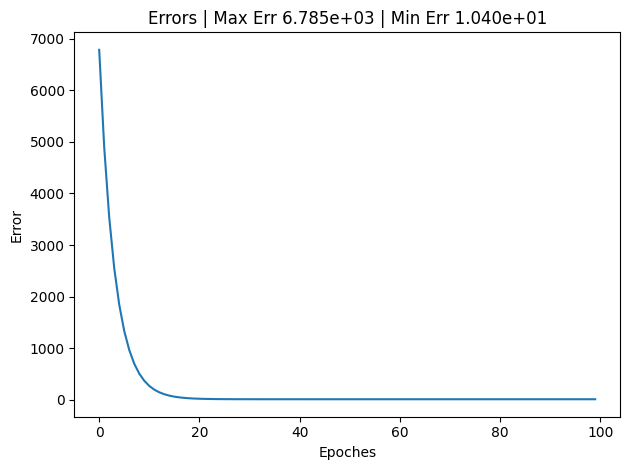

In [7]:
# Plot of error vs epoches
plt.plot(errors)
plt.xlabel("Epoches")
plt.ylabel("Error")
plt.title(f'Errors | Max Err {max(errors):.3e} | Min Err {min(errors):.3e}')

plt.tight_layout()
plt.show()

### Visualizziamo l'andamento della funzione di costo $L(m)$ al variare di $m$


__Andiamo a creare un plot che ci mostra__


- la funzione di costo $L(m)$ in un intervallo sull'asse orizzontale che va da __max(m)__ a __min(m)__


- i valori di $L(m)$ assunti con il il variare del coefficiente angolare $m$ nelle varie epoche

Questo ci permetterà di avere una overview complessiva di come l'errore in ogni epoca si è mosso all'interno della funzione di errore. I tre casi principali sono:

- __Comprotamento nomrale__ i valori assunti da $L(m)$ al variare di $m$ tendono a scendere verso il punto di minimo di $L(m)$

- __Esplosione del gradiente__ i valori assunti da $L(m)$ al variare di $m$ vanno verso gli estremi di $L(m)$

- __Scomparsa del gradiente__ i valori assunti da $L(m)$ al variare di $m$ si muovono in un intervallo $m$ molto ristretto e gli estremi _min(m)_ e _max(m)_ sono molto vicini tra loro


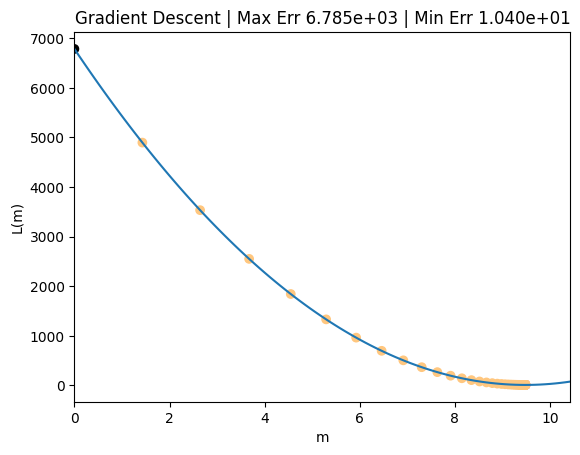

In [8]:
x_axis_min = min(M) - abs(min(M))*0.1
x_axis_max = max(M) + abs(max(M))*0.1


f_error_dict = {}

# Define the range of values for m
horiz = np.linspace(x_axis_min , x_axis_max, len(M)  )

# Calculate the function values for each m value
f_error_values = [ f_error(n, elem, c, X, Y) for elem in horiz]

plt.xlim(x_axis_min, x_axis_max)


# Plot the function values
plt.plot(horiz, f_error_values)


# plot the scatter plot
plt.scatter(M, errors, c=cm.copper(M))

    
plt.xlabel('m')
plt.ylabel('L(m)')
plt.title(f'Gradient Descent | Max Err {max(errors):.3e} | Min Err {min(errors):.3e}')


    
plt.show()

### Animiamo l'andamento della funzione di costo $L(m)$ al variare di $m$

Andiamo a ricreare il plot di cui sopra che ci mostra in maniera animata tramite una gif, l'andamento dei valori di $L(m)$ assunti con il il variare del coefficiente angolare $m$ nelle varie epoche


Questo ci permetterà di avere una overview complessiva di come l'errore in ogni epoca si è mosso all'interno della funzione di errore. I tre casi principali sono:

- __Comprotamento nomrale__ i valori assunti da $L(m)$ al variare di $m$ tendono a scendere verso il punto di minimo di $L(m)$

- __Esplosione del gradiente__ i valori assunti da $L(m)$ al variare di $m$ tendono a _saltare_ da una parte all'altra di $L(m)$

- __Scomparsa del gradiente__ i valori assunti da $L(m)$ al variare di $m$ si muovono talmente lentamente su $L(m)$ da sembrare immobili


__P.S.:__ dato che non avevo mai lavorato con le gif, parte di questo codice è stato fatto con l'ausilio di ChatGPT che ringuazio per il tempo che mi ha risparmiato su diverse cose di questo notebook :)


In [ ]:
gif_filename = "gradient_approach.gif"

# Initialize figure
fig, ax = plt.subplots()

# Set axis labels and title
ax.set_xlabel('m')
ax.set_ylabel('L(m)')


# Initialize empty list for frames
frames = []


print('Starting creating the gif frames')
print('---')

# Create the scatter plot for each point
for i in range(len(M)):

    # Create lists of x and y values for scatter plot
    scatter_x = M[i]
    scatter_y = errors[i]
    
    x_axis_min = M[i] - abs(M[i])*0.5 if M[i] != 0 else -2
    x_axis_max = M[i] + abs(M[i])*0.5 if M[i] != 0 else 2
    
        
    
    ax.set_title(f'Epoch: {i} | m: {scatter_x:.2e} | L(m): {scatter_y:.2e}')
    print(f'Epoch: {i} | m: {scatter_x:.2e} | L(m): {scatter_y:.2e}')

    
    horiz = np.linspace(x_axis_min , x_axis_max, len(M)  )

    # Calculate the function values for each m value
    f_error_values = [ f_error(n, elem, c, X, Y) for elem in horiz]
    


    ax.plot(horiz, f_error_values, zorder=1)

    
    # Plot the scatter plot
    ax.scatter(scatter_x, scatter_y, zorder=2, color='red')

    
    
    # Save the current plot as a PIL image
    fig.canvas.draw()
    frame = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    frames.append(frame)


        
    # Clear the plot for the next iteration
    ax.clear()
    

    

# Close the plot to avoid displaying it
plt.close()

print('---')
print('saving the gif (it can take some time, especially with many epoches)')
print('Please waiting...')

# Save the gif
frames[0].save(gif_filename, format='GIF', append_images=frames[1:], save_all=True, duration=300, loop=0)
print('The gif has been successfully created!')
HTML(f'To open it <a href="{gif_filename}" target="_blank"> click here</a>')